In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
from sklearn.linear_model import LinearRegression

# Visualize activity for different recurrent strengths $r$

In [2]:
all_rs = [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, 0.025]


In [3]:
total_steps = 100000
train_steps = int(total_steps*0.8)
test_steps = int(total_steps*0.2)

In [4]:
dt = 0.0001
start_rec = 1    # in seconds. Exclude spikes collected before this (need to wait for the network to equilibrate)
start_step = int(start_rec/dt)
print(start_step)

10000


In [5]:
train_steps*dt

8.0

0.0025 50690


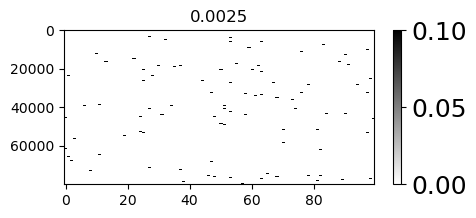

0.005 51792


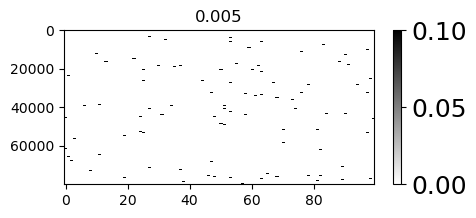

0.0075 52493


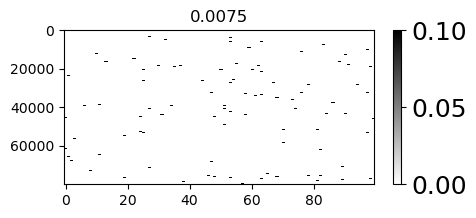

0.01 53097


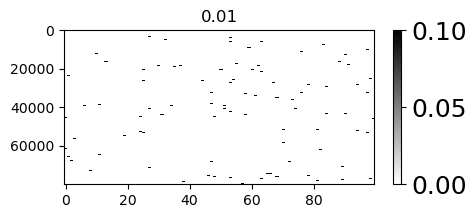

0.0125 49404


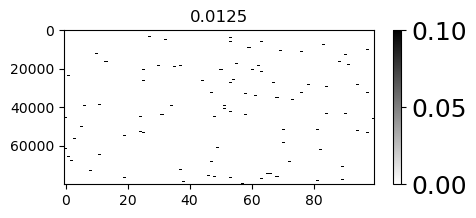

0.015 49380


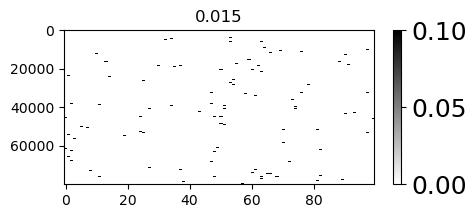

0.0175 49698


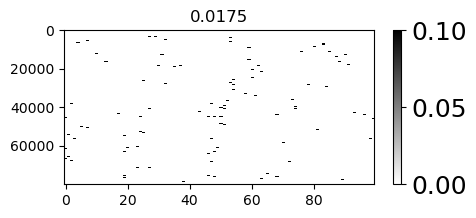

0.02 49625


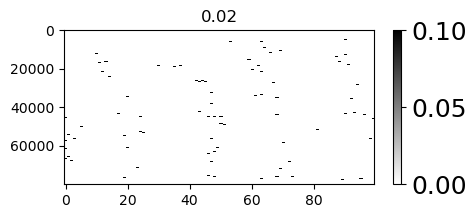

0.0225 49554


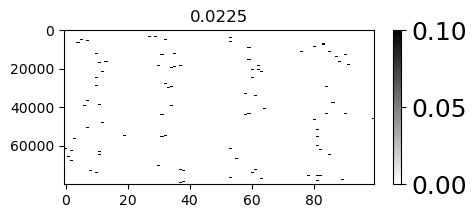

0.025 49590


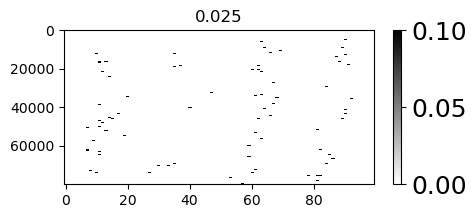

In [7]:
n_spk_allrs = []
for r in all_rs:
    all_spikes = np.load(f'spikes_r{r}.npy')
    fig, ax = plt.subplots(figsize=(5, 2))

    im = ax.imshow(all_spikes[start_step:start_step+train_steps, :], aspect='auto', interpolation='none', vmin=0, vmax=0.1, cmap='binary')
    n_spk = np.sum(all_spikes[start_step:start_step+train_steps, :])
    print(r, n_spk)
    n_spk_allrs.append(n_spk)
    ax.set_title(r)
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=18)
    plt.show()

In [8]:
n_spk_allrs

[50690, 51792, 52493, 53097, 49404, 49380, 49698, 49625, 49554, 49590]

In [9]:
np.mean(n_spk_allrs), np.std(n_spk_allrs)

(50532.3, 1341.5979315726454)

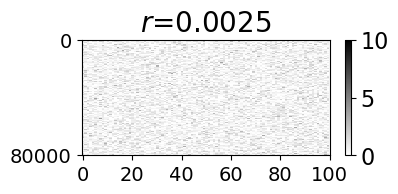

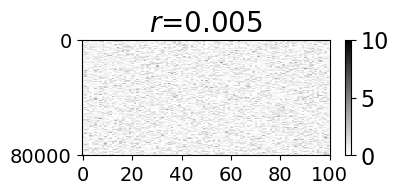

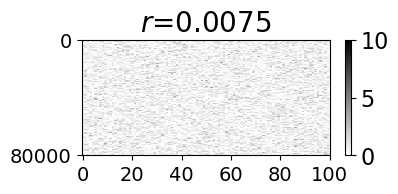

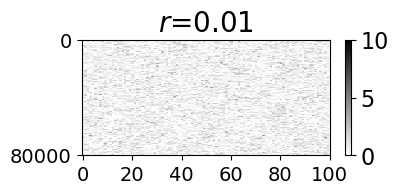

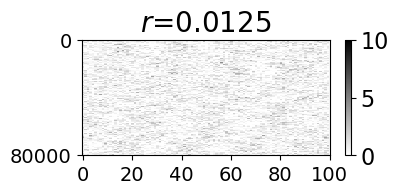

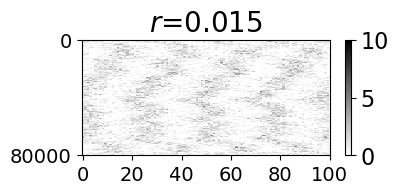

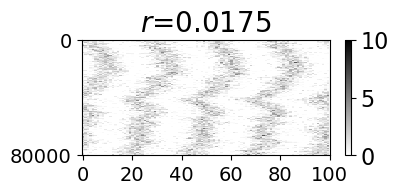

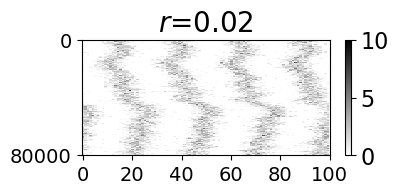

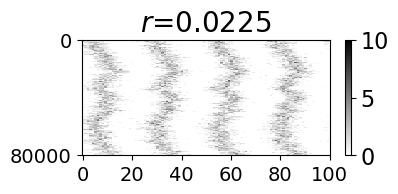

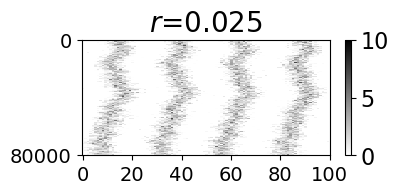

In [11]:
for r in all_rs:
    # all_spikes = np.load(f'Fiete_data/spikes_r{r}.npy')
    activation = np.load(f'activation_r{r}.npy')
    fig, ax = plt.subplots(figsize=(4, 1.5))
    im = ax.imshow(activation[start_step:start_step+train_steps, :], aspect='auto', interpolation='none', vmin=0, vmax=10, cmap='binary', rasterized=True)
    ax.set_title(r'$r$='+str(r), fontsize=20)
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.set_yticks([0, 80000])
    # ax.spines[['top', 'right', 'bottom', 'left']].set_linewidth(2)
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='y', which='major', labelsize=14)
    # ax.xaxis.set_tick_params(width=2, length=4)
    # ax.yaxis.set_tick_params(width=2, length=4)
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=16)
    plt.show()

# Visualize noise correlation for different recurrent strengths $r$

In [12]:
def pairwise_corr(activity):
    # activity: # neurons x # timesteps
    N = activity.shape[0]
    corr_upper = np.diag(np.ones(N))
    for i in range(N):
        for j in range(i+1, N):
            corr_upper[i, j] = np.corrcoef(activity[i], activity[j])[0, 1]
    corr_full = corr_upper + corr_upper.T - np.diag(corr_upper.diagonal())
    return corr_full

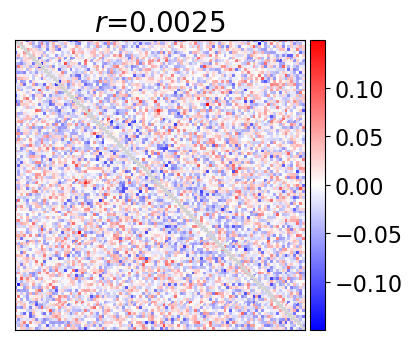

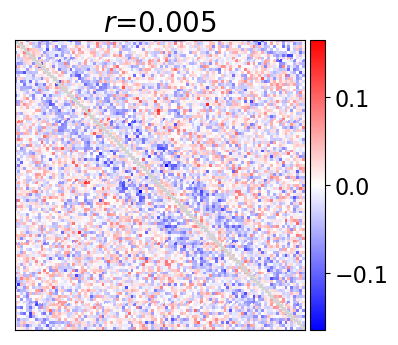

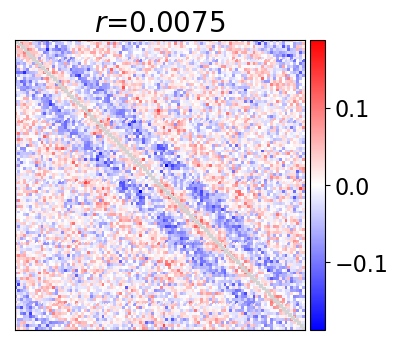

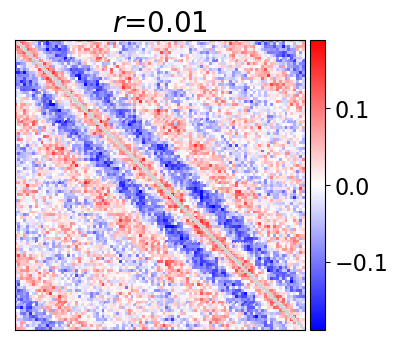

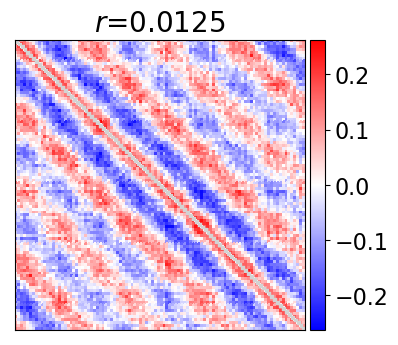

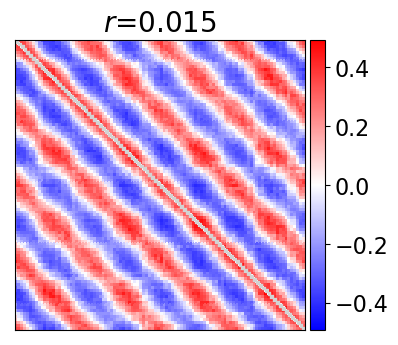

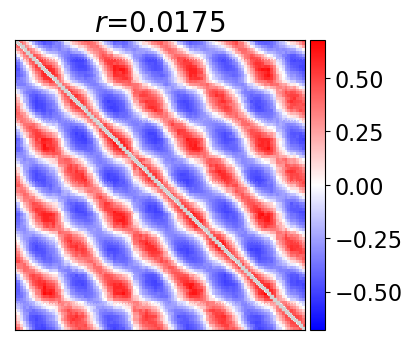

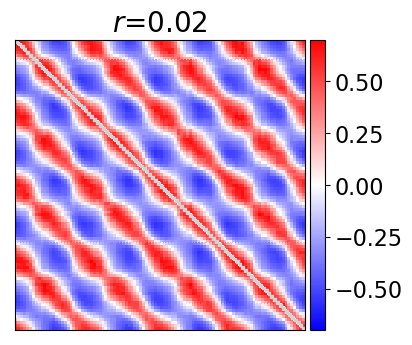

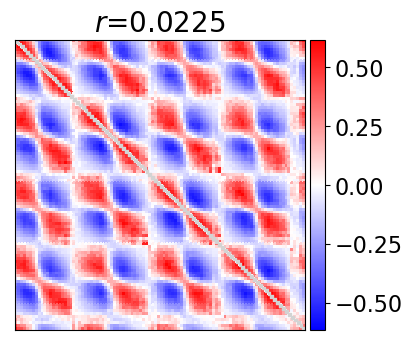

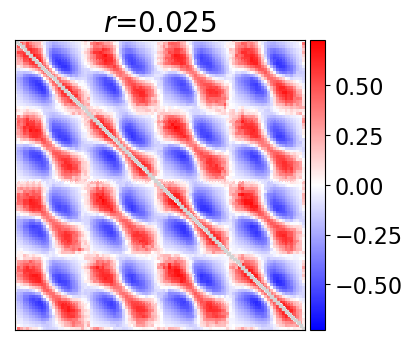

In [13]:
# use activation
for r in all_rs:
    activation = np.load(f'activation_r{r}.npy')
    activation_train = activation[start_step:start_step+train_steps, :].T
    act_corr_mat = pairwise_corr(activation_train)-np.diag(np.ones(100))
            
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

    v = np.max(np.abs(act_corr_mat))
    c = ax.pcolor(act_corr_mat, cmap='bwr', vmax=v, vmin=-v)
    for i in range(100):
        ax.fill_between([i, i+1], i, i+1, color='lightgrey')

    ax.set_title(r'$r$='+str(r), fontsize=20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(c, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=16)
    plt.show()

In [14]:
def bin_spikes(spikes_mat, binsize):
    # spikes_mat: (#neur, #timesteps)
    # binsize: number of timesteps to group as a bin
    bins = np.arange(0, spikes_mat.shape[1]+binsize, binsize)
    spikes_binned = np.zeros((spikes_mat.shape[0], int(spikes_mat.shape[1]/binsize)))
    for i in range(spikes_mat.shape[0]):
        spikes_times = np.nonzero(spikes_mat[i])[0]
        spikes_binned[i] = np.histogram(spikes_times, bins=bins)[0]
    return spikes_binned

In [15]:
binsize=int(10/1000/dt)
print(binsize)

100


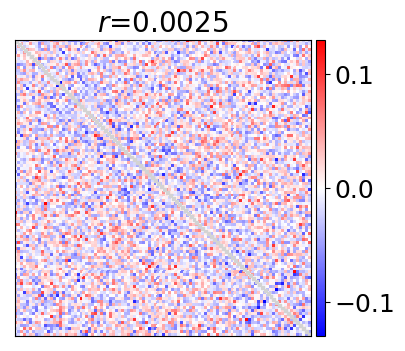

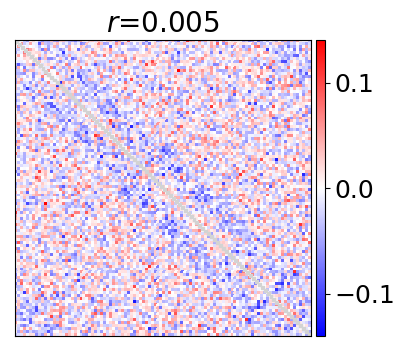

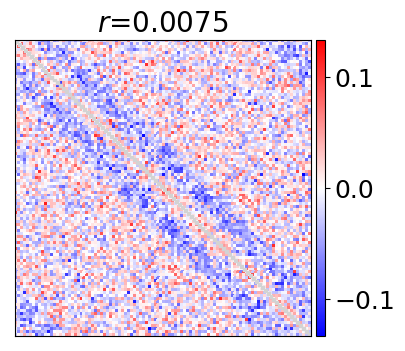

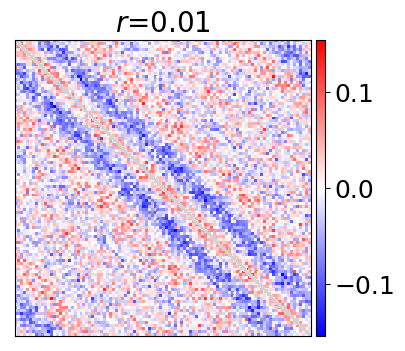

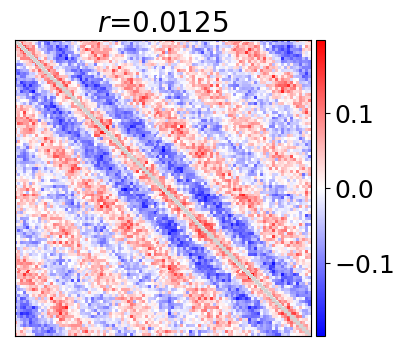

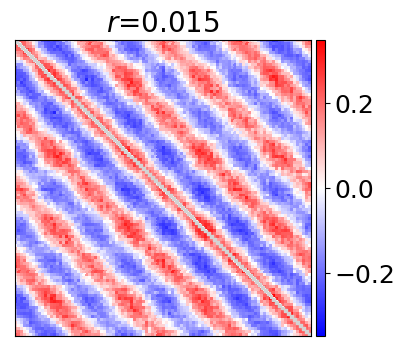

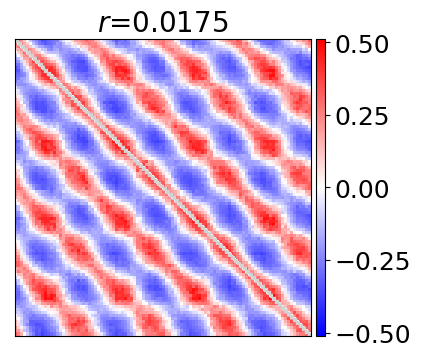

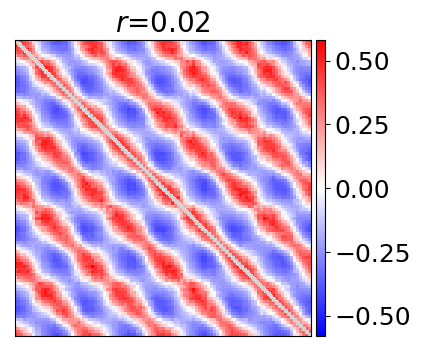

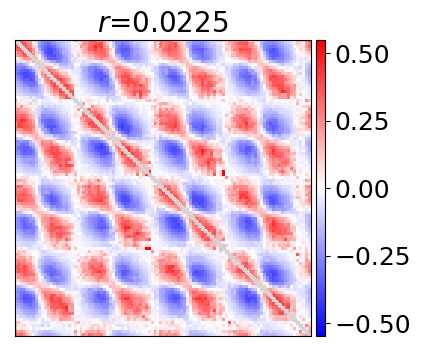

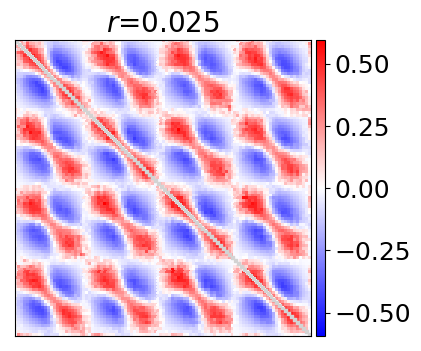

In [16]:
# use binned spike train
for r in all_rs:
    spikes = np.load(f'spikes_r{r}.npy')
    spikes_train = spikes[start_step:start_step+train_steps, :].T
    spikes_binned = bin_spikes(spikes_train, binsize)
    spk_corr_mat = pairwise_corr(spikes_binned)-np.diag(np.ones(100))
            
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

    v = np.max(np.abs(spk_corr_mat))
    c = ax.pcolor(spk_corr_mat, cmap='bwr', vmax=v, vmin=-v)
    for i in range(100):
        ax.fill_between([i, i+1], i, i+1, color='lightgrey')

    ax.set_title(r'$r$='+str(r), fontsize=20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.05)
    cbar = fig.colorbar(c, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=18)
    plt.show()

# Visualize attention weights for different recurrent strengths $r$

In [38]:
# compute correlation from saved attention
res_allrs = {}
for r in all_rs:
    res_allrs[r] = {}

In [39]:
GT = np.load('W.npy')

In [40]:
offdiag_mask = ~np.eye(100, dtype=bool)

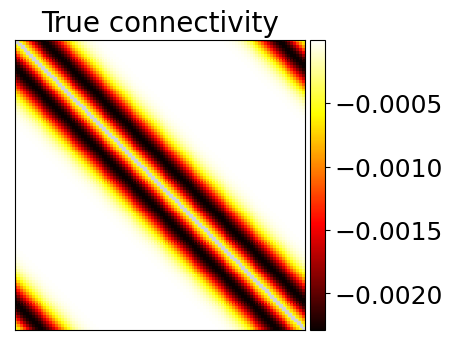

In [41]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')

c = ax.pcolor(GT, cmap='hot')
for i in range(100):
    ax.fill_between([i, i+1], i, i+1, color='lightgrey')

ax.set_title('True connectivity', fontsize=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(c, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=18)
plt.show()

In [42]:
for resdir in os.listdir('./results/'):
    if os.path.isdir(f'./results/{resdir}/'):
        r_ = resdir.split('_')[2]
        r = float(r_[1:])
        res_allrs[r]['filename'] = resdir
        
        res_allrs[r]['spear'] = []
        res_allrs[r]['pear'] = []
        
        for s in range(3):  # load results for 3 seeds
            avg_attn_s = np.load(f'./results/{resdir}/avg_test_attn_seed{s}.npy')
            res_allrs[r]['spear'].append(stats.spearmanr(GT[offdiag_mask].flatten(), avg_attn_s[offdiag_mask].flatten()).correlation)
            res_allrs[r]['pear'].append(np.corrcoef(GT[offdiag_mask].flatten(), avg_attn_s[offdiag_mask].flatten())[0, 1])

## visualize some attention

In [43]:
r_toplot = [0.0025, 0.0075, 0.015, 0.025]

In [44]:
def linear_rescale_rowwise(attn, GT, offdiag=True):
    attn_trans = np.zeros(attn.shape)
    transformations = []
    if offdiag:
        for i in range(attn.shape[0]):
            inferred_row = attn[i]
            true_row = GT[i]

            inferred_row_nodiag = np.delete(inferred_row, i)
            true_row_nodiag = np.delete(true_row, i)
            scale = (1/np.dot(inferred_row_nodiag, inferred_row_nodiag))*np.dot(inferred_row_nodiag, true_row_nodiag)
            transformations.append(scale)
            attn_trans[i] = scale*inferred_row    
    else:
        for i in range(attn.shape[0]):
            inferred_row = attn[i]
            true_row = GT[i]

            scale = (1/np.dot(inferred_row_nodiag, inferred_row_nodiag))*np.dot(inferred_row_nodiag, true_row_nodiag)
            transformations.append(scale)
            attn_trans[i] = scale*inferred_row    
            
    return attn_trans, np.array(transformations)

1 0.09545766779562653 0.10478911116653523


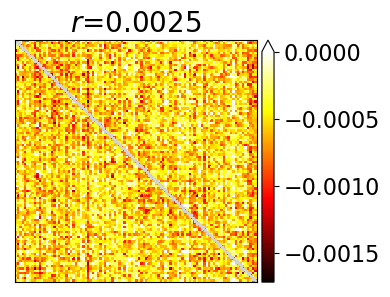

1 0.593801640922649 0.5472232206560332


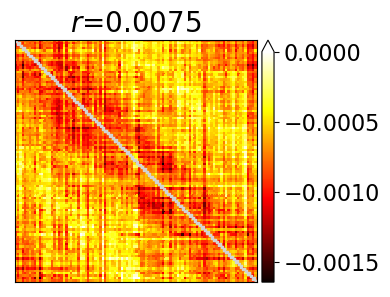

0 0.7354935536048248 0.7900300853062702


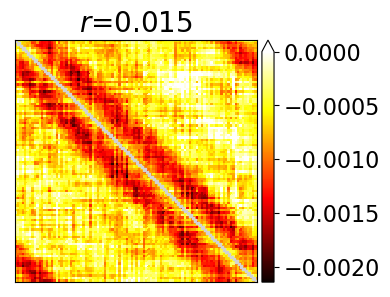

0 0.5642910938065508 0.506818207799733


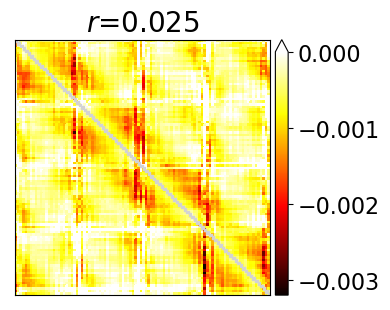

In [45]:
for r in r_toplot:
    # find the attention with average spearman corr
    resdir = './results/'+res_allrs[r]['filename']+'/'
    s = np.argsort(res_allrs[r]['spear'])[1]
    spear_s = res_allrs[r]['spear'][s]
    pear_s = res_allrs[r]['pear'][s]
    print(s, spear_s, pear_s)
    avg_attn_s = np.load(resdir+f'avg_test_attn_seed{s}.npy')
    avg_attn_s, transformations = linear_rescale_rowwise(avg_attn_s, GT, offdiag=True)
    assert transformations.all()>=0
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

    # v = np.min(avg_attn_s[offdiag_mask])

    c = ax.pcolor(avg_attn_s, cmap='hot', vmax=0)

    for i in range(100):
        ax.fill_between([i, i+1], i, i+1, color='lightgrey')
    ax.set_title(r'$r$='+str(r), fontsize=20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(c, cax=cax, orientation='vertical', extend='max')
    cbar.ax.tick_params(labelsize=16)

    plt.tight_layout()
    plt.show()

In [46]:
# compute correlations after transformation
spear_rs_rescale = np.zeros((len(all_rs), 3))
pear_rs_rescale = np.zeros((len(all_rs), 3))
l2_rs_rescale = np.zeros((len(all_rs), 3))

for ir, r in enumerate(all_rs):
    resdir = './results/'+res_allrs[r]['filename']+'/'
    for s in range(3):
        avg_attn_s = np.load(resdir+f'avg_test_attn_seed{s}.npy')

        avg_attn_s, transformations = linear_rescale_rowwise(avg_attn_s, GT, offdiag=True)
        assert transformations.all()>=0
        spear_rs_rescale[ir, s] = stats.spearmanr(GT[offdiag_mask].flatten(), avg_attn_s[offdiag_mask].flatten()).correlation
        pear_rs_rescale[ir, s] = stats.pearsonr(GT[offdiag_mask].flatten(), avg_attn_s[offdiag_mask].flatten()).statistic
        l2_rs_rescale[ir, s] = np.linalg.norm(GT[offdiag_mask].flatten()-avg_attn_s[offdiag_mask].flatten())/np.linalg.norm(GT[offdiag_mask].flatten())
        

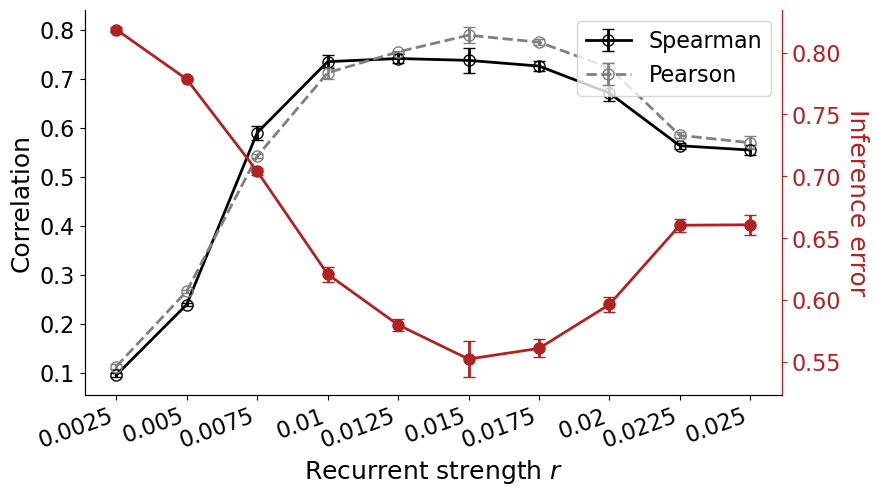

In [47]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.errorbar(x=all_rs, y=np.mean(spear_rs_rescale, axis=1), yerr=np.std(spear_rs_rescale, axis=1), fmt='-o', linewidth=2, ms=8, capsize=4, color='k', markerfacecolor='none', label='Spearman')
ax.errorbar(x=all_rs, y=np.mean(pear_rs_rescale, axis=1), yerr=np.std(pear_rs_rescale, axis=1), fmt='--o', linewidth=2, ms=8, capsize=4, color='grey', markerfacecolor='none', label='Pearson')
ax.set_ylabel('Correlation', fontsize=18)

ax_ = ax.twinx()
ax_.errorbar(x=all_rs, y=np.mean(l2_rs_rescale, axis=1), yerr=np.std(l2_rs_rescale, axis=1), fmt='-o', linewidth=2, ms=8, capsize=4, color='firebrick')
ax_.set_ylabel('Inference error', labelpad=20, rotation=270, fontsize=18)
ax.legend(fontsize=16, loc='upper right')

ax.spines[['top']].set_visible(False)
ax_.spines[['top']].set_visible(False)

ax.set_xlabel(r'Recurrent strength $r$', fontsize=18)
ax.set_xticks(all_rs)
ax.set_xticklabels(all_rs, rotation=20, ha='right')

ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
ax_.tick_params(axis='y', which='major', labelsize=16)
ax_.spines['right'].set_color('firebrick')
ax_.yaxis.label.set_color('firebrick')
ax_.tick_params(axis='y', colors='firebrick')

plt.show()